<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:04:37] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


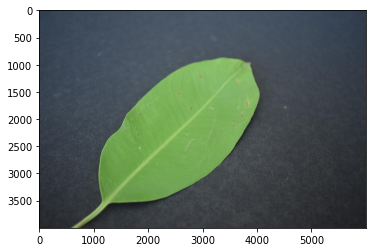

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

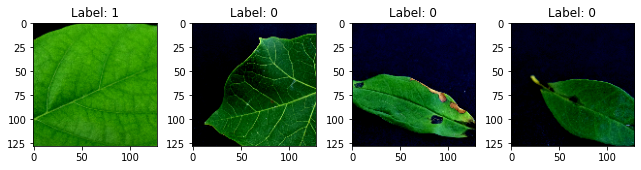

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:04:42] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:04:44] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2623896109915647 samples/sec                   batch loss = 0.9154293537139893 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.231401666719635 samples/sec                   batch loss = 0.539855420589447 | accuracy = 0.65


Epoch[1] Batch[15] Speed: 1.2667106137687716 samples/sec                   batch loss = 0.9463289976119995 | accuracy = 0.5833333333333334


Epoch[1] Batch[20] Speed: 1.2681977265408741 samples/sec                   batch loss = 0.6371333599090576 | accuracy = 0.55


Epoch[1] Batch[25] Speed: 1.267324147913565 samples/sec                   batch loss = 1.2563631534576416 | accuracy = 0.55


Epoch[1] Batch[30] Speed: 1.2671887021124475 samples/sec                   batch loss = 0.4392325282096863 | accuracy = 0.5916666666666667


Epoch[1] Batch[35] Speed: 1.2690809580322138 samples/sec                   batch loss = 0.6536332368850708 | accuracy = 0.6071428571428571


Epoch[1] Batch[40] Speed: 1.2638522129295005 samples/sec                   batch loss = 0.5165897607803345 | accuracy = 0.60625


Epoch[1] Batch[45] Speed: 1.2716201636023594 samples/sec                   batch loss = 0.7735587358474731 | accuracy = 0.5888888888888889


Epoch[1] Batch[50] Speed: 1.2684566112828206 samples/sec                   batch loss = 0.516282320022583 | accuracy = 0.605


Epoch[1] Batch[55] Speed: 1.2660753159091556 samples/sec                   batch loss = 0.6273363828659058 | accuracy = 0.6136363636363636


Epoch[1] Batch[60] Speed: 1.26543206477734 samples/sec                   batch loss = 0.45620161294937134 | accuracy = 0.6208333333333333


Epoch[1] Batch[65] Speed: 1.272571488212121 samples/sec                   batch loss = 0.888917863368988 | accuracy = 0.6192307692307693


Epoch[1] Batch[70] Speed: 1.2703761293212166 samples/sec                   batch loss = 0.38412749767303467 | accuracy = 0.6285714285714286


Epoch[1] Batch[75] Speed: 1.2697052470610868 samples/sec                   batch loss = 0.6955564618110657 | accuracy = 0.64


Epoch[1] Batch[80] Speed: 1.2666563887900277 samples/sec                   batch loss = 1.5925263166427612 | accuracy = 0.634375


Epoch[1] Batch[85] Speed: 1.2790702071431228 samples/sec                   batch loss = 0.27886685729026794 | accuracy = 0.638235294117647


Epoch[1] Batch[90] Speed: 1.2756412605670353 samples/sec                   batch loss = 0.7263464331626892 | accuracy = 0.6361111111111111


Epoch[1] Batch[95] Speed: 1.2697193726999545 samples/sec                   batch loss = 1.0878924131393433 | accuracy = 0.631578947368421


Epoch[1] Batch[100] Speed: 1.2693863987569751 samples/sec                   batch loss = 0.5830743312835693 | accuracy = 0.635


Epoch[1] Batch[105] Speed: 1.277191527237089 samples/sec                   batch loss = 0.591159462928772 | accuracy = 0.6333333333333333


Epoch[1] Batch[110] Speed: 1.27196520757095 samples/sec                   batch loss = 0.8181596994400024 | accuracy = 0.6363636363636364


Epoch[1] Batch[115] Speed: 1.269638082507175 samples/sec                   batch loss = 0.4766421914100647 | accuracy = 0.6413043478260869


Epoch[1] Batch[120] Speed: 1.2712824352053635 samples/sec                   batch loss = 1.0800226926803589 | accuracy = 0.6270833333333333


Epoch[1] Batch[125] Speed: 1.2751130653590965 samples/sec                   batch loss = 0.773394763469696 | accuracy = 0.628


Epoch[1] Batch[130] Speed: 1.2717731398785384 samples/sec                   batch loss = 1.2951698303222656 | accuracy = 0.6288461538461538


Epoch[1] Batch[135] Speed: 1.268306541140433 samples/sec                   batch loss = 0.38372603058815 | accuracy = 0.6259259259259259


Epoch[1] Batch[140] Speed: 1.2685808175840263 samples/sec                   batch loss = 0.5484360456466675 | accuracy = 0.6285714285714286


Epoch[1] Batch[145] Speed: 1.2732164157730792 samples/sec                   batch loss = 0.6014323830604553 | accuracy = 0.6224137931034482


Epoch[1] Batch[150] Speed: 1.2713112387028322 samples/sec                   batch loss = 0.7663425207138062 | accuracy = 0.6266666666666667


Epoch[1] Batch[155] Speed: 1.2664522499600488 samples/sec                   batch loss = 1.0481438636779785 | accuracy = 0.6290322580645161


Epoch[1] Batch[160] Speed: 1.2721933150844151 samples/sec                   batch loss = 1.373643159866333 | accuracy = 0.628125


Epoch[1] Batch[165] Speed: 1.2738491334680133 samples/sec                   batch loss = 0.7984603047370911 | accuracy = 0.6287878787878788


Epoch[1] Batch[170] Speed: 1.2740654360149368 samples/sec                   batch loss = 0.23991310596466064 | accuracy = 0.6323529411764706


Epoch[1] Batch[175] Speed: 1.2704120104297083 samples/sec                   batch loss = 1.1442170143127441 | accuracy = 0.6314285714285715


Epoch[1] Batch[180] Speed: 1.2681294752821868 samples/sec                   batch loss = 0.4830322563648224 | accuracy = 0.6347222222222222


Epoch[1] Batch[185] Speed: 1.273626813093781 samples/sec                   batch loss = 0.710722029209137 | accuracy = 0.6351351351351351


Epoch[1] Batch[190] Speed: 1.2698985169090296 samples/sec                   batch loss = 0.570473313331604 | accuracy = 0.6342105263157894


Epoch[1] Batch[195] Speed: 1.2715853707339493 samples/sec                   batch loss = 1.433472752571106 | accuracy = 0.6333333333333333


Epoch[1] Batch[200] Speed: 1.2677908200038297 samples/sec                   batch loss = 0.27875301241874695 | accuracy = 0.63625


Epoch[1] Batch[205] Speed: 1.27036997298085 samples/sec                   batch loss = 0.36705899238586426 | accuracy = 0.6378048780487805


Epoch[1] Batch[210] Speed: 1.2680840424218045 samples/sec                   batch loss = 0.4183984398841858 | accuracy = 0.6416666666666667


Epoch[1] Batch[215] Speed: 1.2722956765861024 samples/sec                   batch loss = 0.28657102584838867 | accuracy = 0.6406976744186047


Epoch[1] Batch[220] Speed: 1.2660139802304542 samples/sec                   batch loss = 0.4878494143486023 | accuracy = 0.6420454545454546


Epoch[1] Batch[225] Speed: 1.2653967507395087 samples/sec                   batch loss = 0.7246226668357849 | accuracy = 0.6422222222222222


Epoch[1] Batch[230] Speed: 1.2713567104256198 samples/sec                   batch loss = 0.14670829474925995 | accuracy = 0.6456521739130435


Epoch[1] Batch[235] Speed: 1.2729225537090985 samples/sec                   batch loss = 1.4675387144088745 | accuracy = 0.6425531914893617


Epoch[1] Batch[240] Speed: 1.2712681784386843 samples/sec                   batch loss = 0.9217066168785095 | accuracy = 0.6395833333333333


Epoch[1] Batch[245] Speed: 1.2680481968506674 samples/sec                   batch loss = 0.39231374859809875 | accuracy = 0.6377551020408163


Epoch[1] Batch[250] Speed: 1.2727331898704275 samples/sec                   batch loss = 0.6523886919021606 | accuracy = 0.638


Epoch[1] Batch[255] Speed: 1.2723027199718016 samples/sec                   batch loss = 0.3553546071052551 | accuracy = 0.638235294117647


Epoch[1] Batch[260] Speed: 1.268633672584058 samples/sec                   batch loss = 0.4896606206893921 | accuracy = 0.6394230769230769


Epoch[1] Batch[265] Speed: 1.2738757320116438 samples/sec                   batch loss = 0.16710112988948822 | accuracy = 0.6415094339622641


Epoch[1] Batch[270] Speed: 1.2707849861303901 samples/sec                   batch loss = 1.7182129621505737 | accuracy = 0.6462962962962963


Epoch[1] Batch[275] Speed: 1.2691489277202628 samples/sec                   batch loss = 0.6255630254745483 | accuracy = 0.6481818181818182


Epoch[1] Batch[280] Speed: 1.2757678480680963 samples/sec                   batch loss = 0.40282267332077026 | accuracy = 0.65


Epoch[1] Batch[285] Speed: 1.2710339508744921 samples/sec                   batch loss = 0.7016745805740356 | accuracy = 0.6482456140350877


Epoch[1] Batch[290] Speed: 1.271838312974479 samples/sec                   batch loss = 0.997355043888092 | accuracy = 0.646551724137931


Epoch[1] Batch[295] Speed: 1.273743233919322 samples/sec                   batch loss = 0.250510036945343 | accuracy = 0.6491525423728813


Epoch[1] Batch[300] Speed: 1.2687428498484818 samples/sec                   batch loss = 0.6871975064277649 | accuracy = 0.65


Epoch[1] Batch[305] Speed: 1.2768033159168146 samples/sec                   batch loss = 0.7323735356330872 | accuracy = 0.6516393442622951


Epoch[1] Batch[310] Speed: 1.2773877638532773 samples/sec                   batch loss = 0.4541589617729187 | accuracy = 0.6524193548387097


Epoch[1] Batch[315] Speed: 1.2776255067943185 samples/sec                   batch loss = 0.33241596817970276 | accuracy = 0.6563492063492063


Epoch[1] Batch[320] Speed: 1.2750793408797927 samples/sec                   batch loss = 0.3908853530883789 | accuracy = 0.65859375


Epoch[1] Batch[325] Speed: 1.2735165036945317 samples/sec                   batch loss = 0.9040395021438599 | accuracy = 0.6607692307692308


Epoch[1] Batch[330] Speed: 1.2763272677948443 samples/sec                   batch loss = 0.7953360080718994 | accuracy = 0.6628787878787878


Epoch[1] Batch[335] Speed: 1.2690854699186667 samples/sec                   batch loss = 1.0561110973358154 | accuracy = 0.6634328358208955


Epoch[1] Batch[340] Speed: 1.2781330979796737 samples/sec                   batch loss = 1.0394419431686401 | accuracy = 0.663235294117647


Epoch[1] Batch[345] Speed: 1.2795855834349303 samples/sec                   batch loss = 0.6575633883476257 | accuracy = 0.663768115942029


Epoch[1] Batch[350] Speed: 1.2795477184616368 samples/sec                   batch loss = 0.8761199116706848 | accuracy = 0.6635714285714286


Epoch[1] Batch[355] Speed: 1.2733892027518878 samples/sec                   batch loss = 0.6636841297149658 | accuracy = 0.6626760563380282


Epoch[1] Batch[360] Speed: 1.2684957408367352 samples/sec                   batch loss = 1.3482446670532227 | accuracy = 0.6645833333333333


Epoch[1] Batch[365] Speed: 1.2738709925534517 samples/sec                   batch loss = 0.5276378393173218 | accuracy = 0.665068493150685


Epoch[1] Batch[370] Speed: 1.2711442158454946 samples/sec                   batch loss = 0.7076285481452942 | accuracy = 0.6662162162162162


Epoch[1] Batch[375] Speed: 1.269578226525648 samples/sec                   batch loss = 0.9761677980422974 | accuracy = 0.6666666666666666


Epoch[1] Batch[380] Speed: 1.2715276438313285 samples/sec                   batch loss = 0.6243480443954468 | accuracy = 0.6677631578947368


Epoch[1] Batch[385] Speed: 1.267986478209687 samples/sec                   batch loss = 0.3926893174648285 | accuracy = 0.6688311688311688


Epoch[1] Batch[390] Speed: 1.2738566776693605 samples/sec                   batch loss = 0.391116738319397 | accuracy = 0.6692307692307692


Epoch[1] Batch[395] Speed: 1.2674029399562272 samples/sec                   batch loss = 0.6662526726722717 | accuracy = 0.669620253164557


Epoch[1] Batch[400] Speed: 1.2753807924667373 samples/sec                   batch loss = 0.21820421516895294 | accuracy = 0.670625


Epoch[1] Batch[405] Speed: 1.2634989953968019 samples/sec                   batch loss = 0.442405104637146 | accuracy = 0.6697530864197531


Epoch[1] Batch[410] Speed: 1.270460785052419 samples/sec                   batch loss = 0.812961220741272 | accuracy = 0.6682926829268293


Epoch[1] Batch[415] Speed: 1.270894534004267 samples/sec                   batch loss = 0.1594383269548416 | accuracy = 0.6692771084337349


Epoch[1] Batch[420] Speed: 1.266326357318777 samples/sec                   batch loss = 0.24216361343860626 | accuracy = 0.6720238095238096


Epoch[1] Batch[425] Speed: 1.260262912833701 samples/sec                   batch loss = 1.295619010925293 | accuracy = 0.6705882352941176


Epoch[1] Batch[430] Speed: 1.2712845544817641 samples/sec                   batch loss = 1.1748772859573364 | accuracy = 0.6697674418604651


Epoch[1] Batch[435] Speed: 1.2670106086322812 samples/sec                   batch loss = 0.22197605669498444 | accuracy = 0.6718390804597701


Epoch[1] Batch[440] Speed: 1.262028951144605 samples/sec                   batch loss = 0.34960949420928955 | accuracy = 0.6721590909090909


Epoch[1] Batch[445] Speed: 1.2680243328748895 samples/sec                   batch loss = 0.33735033869743347 | accuracy = 0.6735955056179775


Epoch[1] Batch[450] Speed: 1.2688171164757152 samples/sec                   batch loss = 0.3349742889404297 | accuracy = 0.6744444444444444


Epoch[1] Batch[455] Speed: 1.2653788081457156 samples/sec                   batch loss = 0.17423880100250244 | accuracy = 0.6758241758241759


Epoch[1] Batch[460] Speed: 1.2665914588126777 samples/sec                   batch loss = 0.3915327787399292 | accuracy = 0.6755434782608696


Epoch[1] Batch[465] Speed: 1.2720716797135043 samples/sec                   batch loss = 0.23199346661567688 | accuracy = 0.6763440860215054


Epoch[1] Batch[470] Speed: 1.2681114551083592 samples/sec                   batch loss = 0.809650182723999 | accuracy = 0.676063829787234


Epoch[1] Batch[475] Speed: 1.2674345361152624 samples/sec                   batch loss = 0.31051141023635864 | accuracy = 0.6768421052631579


Epoch[1] Batch[480] Speed: 1.263736736377305 samples/sec                   batch loss = 0.5296769142150879 | accuracy = 0.6776041666666667


Epoch[1] Batch[485] Speed: 1.2658716508535979 samples/sec                   batch loss = 0.6309618353843689 | accuracy = 0.6783505154639176


Epoch[1] Batch[490] Speed: 1.2729058457089848 samples/sec                   batch loss = 0.5185064673423767 | accuracy = 0.6780612244897959


Epoch[1] Batch[495] Speed: 1.2736255561744234 samples/sec                   batch loss = 0.2628559172153473 | accuracy = 0.6772727272727272


Epoch[1] Batch[500] Speed: 1.2689763296642638 samples/sec                   batch loss = 0.4879642724990845 | accuracy = 0.676


Epoch[1] Batch[505] Speed: 1.2708773978535122 samples/sec                   batch loss = 0.24306704103946686 | accuracy = 0.6772277227722773


Epoch[1] Batch[510] Speed: 1.2788751105385285 samples/sec                   batch loss = 0.42041343450546265 | accuracy = 0.6769607843137255


Epoch[1] Batch[515] Speed: 1.2773408871881244 samples/sec                   batch loss = 0.6470344066619873 | accuracy = 0.6771844660194175


Epoch[1] Batch[520] Speed: 1.2684629408999295 samples/sec                   batch loss = 1.1984649896621704 | accuracy = 0.676923076923077


Epoch[1] Batch[525] Speed: 1.2719046498482558 samples/sec                   batch loss = 0.6254346966743469 | accuracy = 0.6747619047619048


Epoch[1] Batch[530] Speed: 1.270008873369702 samples/sec                   batch loss = 0.3404492735862732 | accuracy = 0.6759433962264151


Epoch[1] Batch[535] Speed: 1.2693970596702757 samples/sec                   batch loss = 0.3536809980869293 | accuracy = 0.6757009345794392


Epoch[1] Batch[540] Speed: 1.2663932675273228 samples/sec                   batch loss = 0.6917818784713745 | accuracy = 0.6759259259259259


Epoch[1] Batch[545] Speed: 1.2741677119410997 samples/sec                   batch loss = 1.0711655616760254 | accuracy = 0.676605504587156


Epoch[1] Batch[550] Speed: 1.2701903110794344 samples/sec                   batch loss = 0.22499392926692963 | accuracy = 0.6768181818181818


Epoch[1] Batch[555] Speed: 1.2727571348623468 samples/sec                   batch loss = 0.45167359709739685 | accuracy = 0.677027027027027


Epoch[1] Batch[560] Speed: 1.2797329658766423 samples/sec                   batch loss = 0.7040467262268066 | accuracy = 0.6763392857142857


Epoch[1] Batch[565] Speed: 1.2749092920214442 samples/sec                   batch loss = 0.8328295350074768 | accuracy = 0.6769911504424779


Epoch[1] Batch[570] Speed: 1.2757774522831005 samples/sec                   batch loss = 0.6867639422416687 | accuracy = 0.6776315789473685


Epoch[1] Batch[575] Speed: 1.278701221514738 samples/sec                   batch loss = 0.6543020009994507 | accuracy = 0.678695652173913


Epoch[1] Batch[580] Speed: 1.2778662581690758 samples/sec                   batch loss = 0.3092983663082123 | accuracy = 0.680603448275862


Epoch[1] Batch[585] Speed: 1.2721720923295237 samples/sec                   batch loss = 0.9533640742301941 | accuracy = 0.6816239316239316


Epoch[1] Batch[590] Speed: 1.2793839880105335 samples/sec                   batch loss = 0.6269296407699585 | accuracy = 0.6822033898305084


Epoch[1] Batch[595] Speed: 1.2753684795944051 samples/sec                   batch loss = 0.2618269920349121 | accuracy = 0.6823529411764706


Epoch[1] Batch[600] Speed: 1.2763521250186673 samples/sec                   batch loss = 0.4321128726005554 | accuracy = 0.6820833333333334


Epoch[1] Batch[605] Speed: 1.275818102026568 samples/sec                   batch loss = 0.49756062030792236 | accuracy = 0.6830578512396694


Epoch[1] Batch[610] Speed: 1.2731752553223459 samples/sec                   batch loss = 0.6549348831176758 | accuracy = 0.6827868852459016


Epoch[1] Batch[615] Speed: 1.27330908483748 samples/sec                   batch loss = 0.6155557632446289 | accuracy = 0.6817073170731708


Epoch[1] Batch[620] Speed: 1.2720984934429047 samples/sec                   batch loss = 0.3630848526954651 | accuracy = 0.682258064516129


Epoch[1] Batch[625] Speed: 1.276769987791049 samples/sec                   batch loss = 0.5504801273345947 | accuracy = 0.6832


Epoch[1] Batch[630] Speed: 1.2696377942626005 samples/sec                   batch loss = 0.3821730613708496 | accuracy = 0.682936507936508


Epoch[1] Batch[635] Speed: 1.2679501590226487 samples/sec                   batch loss = 0.6846258044242859 | accuracy = 0.6834645669291338


Epoch[1] Batch[640] Speed: 1.2673583250326976 samples/sec                   batch loss = 0.7572099566459656 | accuracy = 0.683984375


Epoch[1] Batch[645] Speed: 1.2724575011719852 samples/sec                   batch loss = 0.49409544467926025 | accuracy = 0.6833333333333333


Epoch[1] Batch[650] Speed: 1.2720779490094154 samples/sec                   batch loss = 0.21938163042068481 | accuracy = 0.6842307692307692


Epoch[1] Batch[655] Speed: 1.2774197625569386 samples/sec                   batch loss = 0.41131678223609924 | accuracy = 0.684351145038168


Epoch[1] Batch[660] Speed: 1.2707682379442558 samples/sec                   batch loss = 0.6260855197906494 | accuracy = 0.6848484848484848


Epoch[1] Batch[665] Speed: 1.27249118361621 samples/sec                   batch loss = 0.5742254853248596 | accuracy = 0.6860902255639098


Epoch[1] Batch[670] Speed: 1.268357934967196 samples/sec                   batch loss = 0.19714021682739258 | accuracy = 0.6876865671641791


Epoch[1] Batch[675] Speed: 1.2735528524461093 samples/sec                   batch loss = 0.4359951615333557 | accuracy = 0.6885185185185185


Epoch[1] Batch[680] Speed: 1.2740474402470938 samples/sec                   batch loss = 0.4726268947124481 | accuracy = 0.6882352941176471


Epoch[1] Batch[685] Speed: 1.2741232968208842 samples/sec                   batch loss = 0.12985897064208984 | accuracy = 0.6886861313868613


Epoch[1] Batch[690] Speed: 1.2761198060036871 samples/sec                   batch loss = 0.585761547088623 | accuracy = 0.6898550724637681


Epoch[1] Batch[695] Speed: 1.2758562317059539 samples/sec                   batch loss = 0.37758755683898926 | accuracy = 0.6902877697841726


Epoch[1] Batch[700] Speed: 1.2723237541083425 samples/sec                   batch loss = 0.40387576818466187 | accuracy = 0.6903571428571429


Epoch[1] Batch[705] Speed: 1.276376206377569 samples/sec                   batch loss = 0.23316429555416107 | accuracy = 0.6911347517730496


Epoch[1] Batch[710] Speed: 1.275110351829251 samples/sec                   batch loss = 1.261903166770935 | accuracy = 0.6904929577464789


Epoch[1] Batch[715] Speed: 1.2789555404582926 samples/sec                   batch loss = 0.21802254021167755 | accuracy = 0.6909090909090909


Epoch[1] Batch[720] Speed: 1.2788733558166798 samples/sec                   batch loss = 0.7527669072151184 | accuracy = 0.690625


Epoch[1] Batch[725] Speed: 1.2731708109258306 samples/sec                   batch loss = 0.5919060707092285 | accuracy = 0.6913793103448276


Epoch[1] Batch[730] Speed: 1.2726456245281783 samples/sec                   batch loss = 0.24168652296066284 | accuracy = 0.6914383561643835


Epoch[1] Batch[735] Speed: 1.2718835331449247 samples/sec                   batch loss = 0.3140939176082611 | accuracy = 0.6908163265306122


Epoch[1] Batch[740] Speed: 1.272027603485206 samples/sec                   batch loss = 0.4301988482475281 | accuracy = 0.6905405405405406


Epoch[1] Batch[745] Speed: 1.2689665396355012 samples/sec                   batch loss = 0.40258631110191345 | accuracy = 0.6909395973154362


Epoch[1] Batch[750] Speed: 1.2718398556138837 samples/sec                   batch loss = 0.6911206245422363 | accuracy = 0.6906666666666667


Epoch[1] Batch[755] Speed: 1.2668058773538995 samples/sec                   batch loss = 0.28509271144866943 | accuracy = 0.6917218543046357


Epoch[1] Batch[760] Speed: 1.2742641004997646 samples/sec                   batch loss = 0.4837963283061981 | accuracy = 0.6924342105263158


Epoch[1] Batch[765] Speed: 1.2735309076058656 samples/sec                   batch loss = 0.4520794451236725 | accuracy = 0.6928104575163399


Epoch[1] Batch[770] Speed: 1.269823643089768 samples/sec                   batch loss = 0.7314966917037964 | accuracy = 0.6928571428571428


Epoch[1] Batch[775] Speed: 1.2706872946009322 samples/sec                   batch loss = 0.2736240029335022 | accuracy = 0.6932258064516129


Epoch[1] Batch[780] Speed: 1.2688486872232583 samples/sec                   batch loss = 1.137501835823059 | accuracy = 0.6939102564102564


Epoch[1] Batch[785] Speed: 1.2723304118469219 samples/sec                   batch loss = 1.1287833452224731 | accuracy = 0.6952229299363057


[Epoch 1] training: accuracy=0.6954314720812182
[Epoch 1] time cost: 646.2175014019012
[Epoch 1] validation: validation accuracy=0.7933333333333333


Epoch[2] Batch[5] Speed: 1.2764329176832718 samples/sec                   batch loss = 0.5025748014450073 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.2812259777994965 samples/sec                   batch loss = 0.5621280670166016 | accuracy = 0.775


Epoch[2] Batch[15] Speed: 1.2804716581089286 samples/sec                   batch loss = 0.352102667093277 | accuracy = 0.7833333333333333


Epoch[2] Batch[20] Speed: 1.2733664903770876 samples/sec                   batch loss = 1.0112667083740234 | accuracy = 0.75


Epoch[2] Batch[25] Speed: 1.2712334048287153 samples/sec                   batch loss = 0.47495245933532715 | accuracy = 0.75


Epoch[2] Batch[30] Speed: 1.2722427089647101 samples/sec                   batch loss = 0.5356131792068481 | accuracy = 0.7666666666666667


Epoch[2] Batch[35] Speed: 1.2756955785631154 samples/sec                   batch loss = 0.8405478000640869 | accuracy = 0.7571428571428571


Epoch[2] Batch[40] Speed: 1.2879564761221378 samples/sec                   batch loss = 0.7815929651260376 | accuracy = 0.7625


Epoch[2] Batch[45] Speed: 1.271159336638694 samples/sec                   batch loss = 0.17944902181625366 | accuracy = 0.7833333333333333


Epoch[2] Batch[50] Speed: 1.2760342974010748 samples/sec                   batch loss = 0.9620414972305298 | accuracy = 0.765


Epoch[2] Batch[55] Speed: 1.274167905477811 samples/sec                   batch loss = 0.5257161855697632 | accuracy = 0.7545454545454545


Epoch[2] Batch[60] Speed: 1.2745679747286744 samples/sec                   batch loss = 0.7394983768463135 | accuracy = 0.75


Epoch[2] Batch[65] Speed: 1.2738595793090572 samples/sec                   batch loss = 0.7995847463607788 | accuracy = 0.75


Epoch[2] Batch[70] Speed: 1.272514443880727 samples/sec                   batch loss = 0.17658865451812744 | accuracy = 0.7678571428571429


Epoch[2] Batch[75] Speed: 1.2718400484440724 samples/sec                   batch loss = 0.46292296051979065 | accuracy = 0.7566666666666667


Epoch[2] Batch[80] Speed: 1.272825885168564 samples/sec                   batch loss = 0.6150591969490051 | accuracy = 0.75


Epoch[2] Batch[85] Speed: 1.2721323498022445 samples/sec                   batch loss = 0.8726147413253784 | accuracy = 0.7470588235294118


Epoch[2] Batch[90] Speed: 1.2752066892117246 samples/sec                   batch loss = 0.4087362587451935 | accuracy = 0.75


Epoch[2] Batch[95] Speed: 1.2708142483886082 samples/sec                   batch loss = 0.3899100422859192 | accuracy = 0.7526315789473684


Epoch[2] Batch[100] Speed: 1.2749686828497528 samples/sec                   batch loss = 0.23222136497497559 | accuracy = 0.75


Epoch[2] Batch[105] Speed: 1.2733983845801844 samples/sec                   batch loss = 0.6841545701026917 | accuracy = 0.7452380952380953


Epoch[2] Batch[110] Speed: 1.2738898538716732 samples/sec                   batch loss = 0.4168652296066284 | accuracy = 0.7522727272727273


Epoch[2] Batch[115] Speed: 1.2731928399780288 samples/sec                   batch loss = 0.5573196411132812 | accuracy = 0.7543478260869565


Epoch[2] Batch[120] Speed: 1.2755835527642825 samples/sec                   batch loss = 0.5068349838256836 | accuracy = 0.75


Epoch[2] Batch[125] Speed: 1.273764702541772 samples/sec                   batch loss = 0.30599281191825867 | accuracy = 0.756


Epoch[2] Batch[130] Speed: 1.279342622942694 samples/sec                   batch loss = 0.6043348908424377 | accuracy = 0.7538461538461538


Epoch[2] Batch[135] Speed: 1.2787393287958755 samples/sec                   batch loss = 0.8184133172035217 | accuracy = 0.7518518518518519


Epoch[2] Batch[140] Speed: 1.274504264334418 samples/sec                   batch loss = 0.37576824426651 | accuracy = 0.7553571428571428


Epoch[2] Batch[145] Speed: 1.2695861045185015 samples/sec                   batch loss = 0.32039105892181396 | accuracy = 0.7586206896551724


Epoch[2] Batch[150] Speed: 1.270743116492779 samples/sec                   batch loss = 0.1720760315656662 | accuracy = 0.7633333333333333


Epoch[2] Batch[155] Speed: 1.276344648330001 samples/sec                   batch loss = 0.6696057319641113 | accuracy = 0.7629032258064516


Epoch[2] Batch[160] Speed: 1.270984169378941 samples/sec                   batch loss = 0.13622713088989258 | accuracy = 0.7625


Epoch[2] Batch[165] Speed: 1.2650581224025435 samples/sec                   batch loss = 0.4442368745803833 | accuracy = 0.7636363636363637


Epoch[2] Batch[170] Speed: 1.2672137789388866 samples/sec                   batch loss = 0.42673492431640625 | accuracy = 0.7647058823529411


Epoch[2] Batch[175] Speed: 1.2708544861941697 samples/sec                   batch loss = 0.4498875141143799 | accuracy = 0.7628571428571429


Epoch[2] Batch[180] Speed: 1.2711034781737742 samples/sec                   batch loss = 0.3905907869338989 | accuracy = 0.7638888888888888


Epoch[2] Batch[185] Speed: 1.2657243879701225 samples/sec                   batch loss = 0.5057055354118347 | accuracy = 0.7621621621621621


Epoch[2] Batch[190] Speed: 1.2636922840064577 samples/sec                   batch loss = 0.7174809575080872 | accuracy = 0.7578947368421053


Epoch[2] Batch[195] Speed: 1.2740563413160362 samples/sec                   batch loss = 0.5756459832191467 | accuracy = 0.7576923076923077


Epoch[2] Batch[200] Speed: 1.2796691285189399 samples/sec                   batch loss = 0.12416732311248779 | accuracy = 0.76125


Epoch[2] Batch[205] Speed: 1.2693981161669317 samples/sec                   batch loss = 0.18689410388469696 | accuracy = 0.7634146341463415


Epoch[2] Batch[210] Speed: 1.2681083878957335 samples/sec                   batch loss = 0.4289563298225403 | accuracy = 0.7619047619047619


Epoch[2] Batch[215] Speed: 1.2699146654370117 samples/sec                   batch loss = 0.399197518825531 | accuracy = 0.7604651162790698


Epoch[2] Batch[220] Speed: 1.2726480379648848 samples/sec                   batch loss = 0.569307804107666 | accuracy = 0.7602272727272728


Epoch[2] Batch[225] Speed: 1.2710534986401334 samples/sec                   batch loss = 0.6614283323287964 | accuracy = 0.7611111111111111


Epoch[2] Batch[230] Speed: 1.2687936073651247 samples/sec                   batch loss = 0.2378668338060379 | accuracy = 0.7619565217391304


Epoch[2] Batch[235] Speed: 1.275187304262751 samples/sec                   batch loss = 0.24518093466758728 | accuracy = 0.7606382978723404


Epoch[2] Batch[240] Speed: 1.272252935520728 samples/sec                   batch loss = 0.3253750801086426 | accuracy = 0.759375


Epoch[2] Batch[245] Speed: 1.2739197429504974 samples/sec                   batch loss = 0.4180702567100525 | accuracy = 0.7612244897959184


Epoch[2] Batch[250] Speed: 1.271509623317566 samples/sec                   batch loss = 0.4525667726993561 | accuracy = 0.764


Epoch[2] Batch[255] Speed: 1.26981383998281 samples/sec                   batch loss = 0.9423736333847046 | accuracy = 0.7647058823529411


Epoch[2] Batch[260] Speed: 1.273922161222087 samples/sec                   batch loss = 0.40504464507102966 | accuracy = 0.7653846153846153


Epoch[2] Batch[265] Speed: 1.2751905996624973 samples/sec                   batch loss = 0.2872650921344757 | accuracy = 0.7650943396226415


Epoch[2] Batch[270] Speed: 1.2747327992496824 samples/sec                   batch loss = 0.9925366640090942 | accuracy = 0.7611111111111111


Epoch[2] Batch[275] Speed: 1.2693063035676755 samples/sec                   batch loss = 0.3219720125198364 | accuracy = 0.7627272727272727


Epoch[2] Batch[280] Speed: 1.2700000287652022 samples/sec                   batch loss = 0.08805444091558456 | accuracy = 0.7625


Epoch[2] Batch[285] Speed: 1.2767152867964668 samples/sec                   batch loss = 0.26460760831832886 | accuracy = 0.7631578947368421


Epoch[2] Batch[290] Speed: 1.265741767409044 samples/sec                   batch loss = 0.7294492721557617 | accuracy = 0.7620689655172413


Epoch[2] Batch[295] Speed: 1.267401120831396 samples/sec                   batch loss = 0.328472375869751 | accuracy = 0.761864406779661


Epoch[2] Batch[300] Speed: 1.275060735034132 samples/sec                   batch loss = 0.35968509316444397 | accuracy = 0.7625


Epoch[2] Batch[305] Speed: 1.2697275407297877 samples/sec                   batch loss = 0.5166313648223877 | accuracy = 0.7639344262295082


Epoch[2] Batch[310] Speed: 1.2695544970647843 samples/sec                   batch loss = 0.317823588848114 | accuracy = 0.7653225806451613


Epoch[2] Batch[315] Speed: 1.2717250356206529 samples/sec                   batch loss = 0.3279856741428375 | accuracy = 0.7658730158730159


Epoch[2] Batch[320] Speed: 1.274402418393757 samples/sec                   batch loss = 0.313222736120224 | accuracy = 0.765625


Epoch[2] Batch[325] Speed: 1.2709548030140112 samples/sec                   batch loss = 0.5374850034713745 | accuracy = 0.7669230769230769


Epoch[2] Batch[330] Speed: 1.2793700367571084 samples/sec                   batch loss = 0.2887345254421234 | accuracy = 0.7681818181818182


Epoch[2] Batch[335] Speed: 1.2711034781737742 samples/sec                   batch loss = 0.15728656947612762 | accuracy = 0.7694029850746269


Epoch[2] Batch[340] Speed: 1.2691845475120687 samples/sec                   batch loss = 0.5043107271194458 | accuracy = 0.7713235294117647


Epoch[2] Batch[345] Speed: 1.2707749756672109 samples/sec                   batch loss = 0.8843292593955994 | accuracy = 0.7717391304347826


Epoch[2] Batch[350] Speed: 1.2677250073352102 samples/sec                   batch loss = 0.4508037269115448 | accuracy = 0.7714285714285715


Epoch[2] Batch[355] Speed: 1.2756030467489534 samples/sec                   batch loss = 0.41372331976890564 | accuracy = 0.7718309859154929


Epoch[2] Batch[360] Speed: 1.2815758635095356 samples/sec                   batch loss = 0.23377661406993866 | accuracy = 0.7715277777777778


Epoch[2] Batch[365] Speed: 1.272549866746926 samples/sec                   batch loss = 0.985281765460968 | accuracy = 0.7712328767123288


Epoch[2] Batch[370] Speed: 1.2754201564724326 samples/sec                   batch loss = 0.6331044435501099 | accuracy = 0.7702702702702703


Epoch[2] Batch[375] Speed: 1.2749439763681305 samples/sec                   batch loss = 0.5848100185394287 | accuracy = 0.7673333333333333


Epoch[2] Batch[380] Speed: 1.2737662498578353 samples/sec                   batch loss = 0.8951426148414612 | accuracy = 0.7651315789473684


Epoch[2] Batch[385] Speed: 1.2677371730633538 samples/sec                   batch loss = 0.5722389221191406 | accuracy = 0.7642857142857142


Epoch[2] Batch[390] Speed: 1.2661810909228128 samples/sec                   batch loss = 0.5531261563301086 | accuracy = 0.7628205128205128


Epoch[2] Batch[395] Speed: 1.26710314209136 samples/sec                   batch loss = 1.3655638694763184 | accuracy = 0.7626582278481012


Epoch[2] Batch[400] Speed: 1.275144077949009 samples/sec                   batch loss = 0.4419867992401123 | accuracy = 0.763125


Epoch[2] Batch[405] Speed: 1.2710969295718177 samples/sec                   batch loss = 0.6678251624107361 | accuracy = 0.7598765432098765


Epoch[2] Batch[410] Speed: 1.267796855568762 samples/sec                   batch loss = 0.4834437072277069 | accuracy = 0.7585365853658537


Epoch[2] Batch[415] Speed: 1.2672243076732967 samples/sec                   batch loss = 0.6717386841773987 | accuracy = 0.7578313253012048


Epoch[2] Batch[420] Speed: 1.2691104298701648 samples/sec                   batch loss = 0.8035122752189636 | accuracy = 0.756547619047619


Epoch[2] Batch[425] Speed: 1.2701460766527868 samples/sec                   batch loss = 0.9190666079521179 | accuracy = 0.7552941176470588


Epoch[2] Batch[430] Speed: 1.26924042948903 samples/sec                   batch loss = 0.44764769077301025 | accuracy = 0.7563953488372093


Epoch[2] Batch[435] Speed: 1.266903546967105 samples/sec                   batch loss = 0.3706555664539337 | accuracy = 0.7563218390804598


Epoch[2] Batch[440] Speed: 1.2703559290527047 samples/sec                   batch loss = 1.097867727279663 | accuracy = 0.7551136363636364


Epoch[2] Batch[445] Speed: 1.2642369696802547 samples/sec                   batch loss = 0.4124299883842468 | accuracy = 0.7544943820224719


Epoch[2] Batch[450] Speed: 1.2679409597699007 samples/sec                   batch loss = 0.3573165833950043 | accuracy = 0.755


Epoch[2] Batch[455] Speed: 1.2752482719152778 samples/sec                   batch loss = 0.4848538637161255 | accuracy = 0.7538461538461538


Epoch[2] Batch[460] Speed: 1.2740764659303794 samples/sec                   batch loss = 0.5426876544952393 | accuracy = 0.753804347826087


Epoch[2] Batch[465] Speed: 1.2773902925678724 samples/sec                   batch loss = 0.3729325830936432 | accuracy = 0.7532258064516129


Epoch[2] Batch[470] Speed: 1.2799880860483934 samples/sec                   batch loss = 0.6105498671531677 | accuracy = 0.7526595744680851


Epoch[2] Batch[475] Speed: 1.275808982288331 samples/sec                   batch loss = 0.2710910439491272 | accuracy = 0.7521052631578947


Epoch[2] Batch[480] Speed: 1.2736825067801825 samples/sec                   batch loss = 0.38308781385421753 | accuracy = 0.7526041666666666


Epoch[2] Batch[485] Speed: 1.2743842195026964 samples/sec                   batch loss = 0.43834662437438965 | accuracy = 0.7515463917525773


Epoch[2] Batch[490] Speed: 1.273212840698817 samples/sec                   batch loss = 0.2229195088148117 | accuracy = 0.7525510204081632


Epoch[2] Batch[495] Speed: 1.2702037743425776 samples/sec                   batch loss = 0.26500779390335083 | accuracy = 0.7540404040404041


Epoch[2] Batch[500] Speed: 1.2727260451683347 samples/sec                   batch loss = 0.13941669464111328 | accuracy = 0.7545


Epoch[2] Batch[505] Speed: 1.2671927219949255 samples/sec                   batch loss = 0.26656070351600647 | accuracy = 0.754950495049505


Epoch[2] Batch[510] Speed: 1.2682438386420312 samples/sec                   batch loss = 0.5198184251785278 | accuracy = 0.7563725490196078


Epoch[2] Batch[515] Speed: 1.2706812314838294 samples/sec                   batch loss = 0.43482527136802673 | accuracy = 0.7548543689320388


Epoch[2] Batch[520] Speed: 1.2791033629075321 samples/sec                   batch loss = 0.4448201060295105 | accuracy = 0.7552884615384615


Epoch[2] Batch[525] Speed: 1.2719051319729575 samples/sec                   batch loss = 0.39579451084136963 | accuracy = 0.7552380952380953


Epoch[2] Batch[530] Speed: 1.2741216518758973 samples/sec                   batch loss = 0.3757968842983246 | accuracy = 0.7547169811320755


Epoch[2] Batch[535] Speed: 1.2755593073460763 samples/sec                   batch loss = 0.271271288394928 | accuracy = 0.755607476635514


Epoch[2] Batch[540] Speed: 1.2748271422150643 samples/sec                   batch loss = 0.3154020607471466 | accuracy = 0.7555555555555555


Epoch[2] Batch[545] Speed: 1.2718882578258746 samples/sec                   batch loss = 0.6800676584243774 | accuracy = 0.755045871559633


Epoch[2] Batch[550] Speed: 1.2697845276737865 samples/sec                   batch loss = 0.7322375774383545 | accuracy = 0.7540909090909091


Epoch[2] Batch[555] Speed: 1.276864729731622 samples/sec                   batch loss = 0.533654510974884 | accuracy = 0.7545045045045045


Epoch[2] Batch[560] Speed: 1.2689455203781994 samples/sec                   batch loss = 0.3584361672401428 | accuracy = 0.7553571428571428


Epoch[2] Batch[565] Speed: 1.273436466418318 samples/sec                   batch loss = 0.4403221905231476 | accuracy = 0.7561946902654867


Epoch[2] Batch[570] Speed: 1.2736829902536455 samples/sec                   batch loss = 0.16745959222316742 | accuracy = 0.7557017543859649


Epoch[2] Batch[575] Speed: 1.2802238672717123 samples/sec                   batch loss = 0.8207719326019287 | accuracy = 0.7547826086956522


Epoch[2] Batch[580] Speed: 1.263774147326885 samples/sec                   batch loss = 0.1813766062259674 | accuracy = 0.7556034482758621


Epoch[2] Batch[585] Speed: 1.2810175074210939 samples/sec                   batch loss = 0.7915681600570679 | accuracy = 0.7564102564102564


Epoch[2] Batch[590] Speed: 1.27309564735439 samples/sec                   batch loss = 0.3703102171421051 | accuracy = 0.7559322033898305


Epoch[2] Batch[595] Speed: 1.2725962958875348 samples/sec                   batch loss = 0.2322627454996109 | accuracy = 0.7567226890756302


Epoch[2] Batch[600] Speed: 1.2719272136760171 samples/sec                   batch loss = 0.5213050842285156 | accuracy = 0.7583333333333333


Epoch[2] Batch[605] Speed: 1.273738978962965 samples/sec                   batch loss = 0.14848081767559052 | accuracy = 0.759090909090909


Epoch[2] Batch[610] Speed: 1.2696457690774363 samples/sec                   batch loss = 0.4244905114173889 | accuracy = 0.7581967213114754


Epoch[2] Batch[615] Speed: 1.2717071059064375 samples/sec                   batch loss = 0.8131291270256042 | accuracy = 0.7573170731707317


Epoch[2] Batch[620] Speed: 1.272931245905724 samples/sec                   batch loss = 0.3932172656059265 | accuracy = 0.7576612903225807


Epoch[2] Batch[625] Speed: 1.2679544712183255 samples/sec                   batch loss = 0.5621680617332458 | accuracy = 0.7576


Epoch[2] Batch[630] Speed: 1.2702645549115268 samples/sec                   batch loss = 0.7552329301834106 | accuracy = 0.7571428571428571


Epoch[2] Batch[635] Speed: 1.2697468561360594 samples/sec                   batch loss = 0.5635979771614075 | accuracy = 0.75748031496063


Epoch[2] Batch[640] Speed: 1.2720932849321858 samples/sec                   batch loss = 0.47705864906311035 | accuracy = 0.757421875


Epoch[2] Batch[645] Speed: 1.2782596935858124 samples/sec                   batch loss = 0.23043422400951385 | accuracy = 0.7577519379844961


Epoch[2] Batch[650] Speed: 1.2784692157080595 samples/sec                   batch loss = 0.6177961230278015 | accuracy = 0.7580769230769231


Epoch[2] Batch[655] Speed: 1.274629754719173 samples/sec                   batch loss = 0.24747170507907867 | accuracy = 0.7576335877862596


Epoch[2] Batch[660] Speed: 1.2693735290641712 samples/sec                   batch loss = 0.4844056963920593 | accuracy = 0.7583333333333333


Epoch[2] Batch[665] Speed: 1.2689026202195446 samples/sec                   batch loss = 0.7824183106422424 | accuracy = 0.7571428571428571


Epoch[2] Batch[670] Speed: 1.271154039504598 samples/sec                   batch loss = 0.6138128638267517 | accuracy = 0.7582089552238805


Epoch[2] Batch[675] Speed: 1.2630346212476924 samples/sec                   batch loss = 0.7435223460197449 | accuracy = 0.7562962962962962


Epoch[2] Batch[680] Speed: 1.2675446562540515 samples/sec                   batch loss = 0.33103060722351074 | accuracy = 0.7573529411764706


Epoch[2] Batch[685] Speed: 1.2662687246218356 samples/sec                   batch loss = 0.42732012271881104 | accuracy = 0.7580291970802919


Epoch[2] Batch[690] Speed: 1.2690935337956384 samples/sec                   batch loss = 1.0683069229125977 | accuracy = 0.7579710144927536


Epoch[2] Batch[695] Speed: 1.2692005818714616 samples/sec                   batch loss = 0.7963885068893433 | accuracy = 0.7575539568345324


Epoch[2] Batch[700] Speed: 1.2705040792750413 samples/sec                   batch loss = 0.3471457064151764 | accuracy = 0.7571428571428571


Epoch[2] Batch[705] Speed: 1.266209950408862 samples/sec                   batch loss = 0.5442617535591125 | accuracy = 0.7578014184397163


Epoch[2] Batch[710] Speed: 1.2671130947885367 samples/sec                   batch loss = 0.1603160947561264 | accuracy = 0.7580985915492958


Epoch[2] Batch[715] Speed: 1.2715599278470844 samples/sec                   batch loss = 0.5365402102470398 | accuracy = 0.7576923076923077


Epoch[2] Batch[720] Speed: 1.2682612873385581 samples/sec                   batch loss = 1.3032046556472778 | accuracy = 0.7576388888888889


Epoch[2] Batch[725] Speed: 1.2677001976368807 samples/sec                   batch loss = 0.2270355224609375 | accuracy = 0.7582758620689655


Epoch[2] Batch[730] Speed: 1.2613892350306972 samples/sec                   batch loss = 0.2101178616285324 | accuracy = 0.7585616438356164


Epoch[2] Batch[735] Speed: 1.267857310191123 samples/sec                   batch loss = 0.5545984506607056 | accuracy = 0.758843537414966


Epoch[2] Batch[740] Speed: 1.2673295089083951 samples/sec                   batch loss = 0.7765684127807617 | accuracy = 0.7587837837837837


Epoch[2] Batch[745] Speed: 1.2694739003778863 samples/sec                   batch loss = 0.37177661061286926 | accuracy = 0.7590604026845638


Epoch[2] Batch[750] Speed: 1.2744802535588247 samples/sec                   batch loss = 0.2309345006942749 | accuracy = 0.759


Epoch[2] Batch[755] Speed: 1.2710539801197807 samples/sec                   batch loss = 0.26845723390579224 | accuracy = 0.7589403973509934


Epoch[2] Batch[760] Speed: 1.266190455777413 samples/sec                   batch loss = 0.18622851371765137 | accuracy = 0.7588815789473684


Epoch[2] Batch[765] Speed: 1.2745720415658444 samples/sec                   batch loss = 0.34823545813560486 | accuracy = 0.7591503267973856


Epoch[2] Batch[770] Speed: 1.2771889020815925 samples/sec                   batch loss = 0.4681556224822998 | accuracy = 0.759090909090909


Epoch[2] Batch[775] Speed: 1.2742626487566853 samples/sec                   batch loss = 0.25983017683029175 | accuracy = 0.7590322580645161


Epoch[2] Batch[780] Speed: 1.2714744510589433 samples/sec                   batch loss = 0.5894920229911804 | accuracy = 0.7589743589743589


Epoch[2] Batch[785] Speed: 1.2812359579049493 samples/sec                   batch loss = 0.9755167365074158 | accuracy = 0.7576433121019108


[Epoch 2] training: accuracy=0.7572969543147208
[Epoch 2] time cost: 637.5475077629089
[Epoch 2] validation: validation accuracy=0.77


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7755555555555556

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)